In [2]:
!pip install matplotlib


In [2]:
import sys
print(sys.executable)



/Library/Frameworks/Python.framework/Versions/3.12/bin/python3


In [1]:
import sys
print(sys.executable)


/Users/himanshusrivastava/icr_ai_project/venv/bin/python3.13


In [2]:
import matplotlib.pyplot as plt


Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


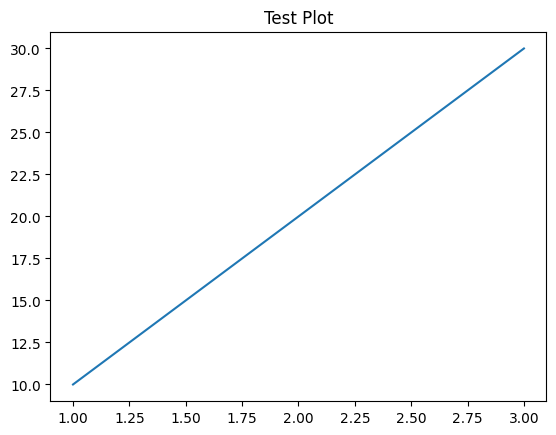

In [3]:
plt.plot([1, 2, 3], [10, 20, 30])
plt.title("Test Plot")
plt.show()


In [23]:
import pandas as pd  # ✅ make sure pandas is imported

# Load the dataset
df = pd.read_csv("CMaps/train_FD001.txt", sep=r"\s+", header=None)

# Add column names from NASA documentation
df.columns = ['unit_number', 'time_in_cycles'] + \
             [f'op_setting_{i}' for i in range(1, 4)] + \
             [f'sensor_{i}' for i in range(1, 22)]

# Preview the dataset
df.head()



,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [7]:
# Step 1: Get the max cycle for each engine
max_cycles = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycle']

# Step 2: Merge max_cycle with the main dataframe
df = df.merge(max_cycles, on='unit_number', how='left')

# Step 3: Compute RUL = max_cycle - current cycle
df['RUL'] = df['max_cycle'] - df['time_in_cycles']

# Drop max_cycle column
df.drop('max_cycle', axis=1, inplace=True)

# Preview updated dataframe
df[['unit_number', 'time_in_cycles', 'RUL']].head(10)


,unit_number,time_in_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187
5,1,6,186
6,1,7,185
7,1,8,184
8,1,9,183
9,1,10,182


In [9]:
from sklearn.model_selection import train_test_split

# Drop ID and cycle info; keep only sensor & op_setting columns
X = df.drop(columns=['unit_number', 'time_in_cycles', 'RUL'])  # Features
y = df['RUL']                                                  # Target

# Split the dataset: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Optional: check dimensions
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


Training samples: 16504
Test samples: 4127


In [13]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train it
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 29.69
Root Mean Squared Error (RMSE): 41.52


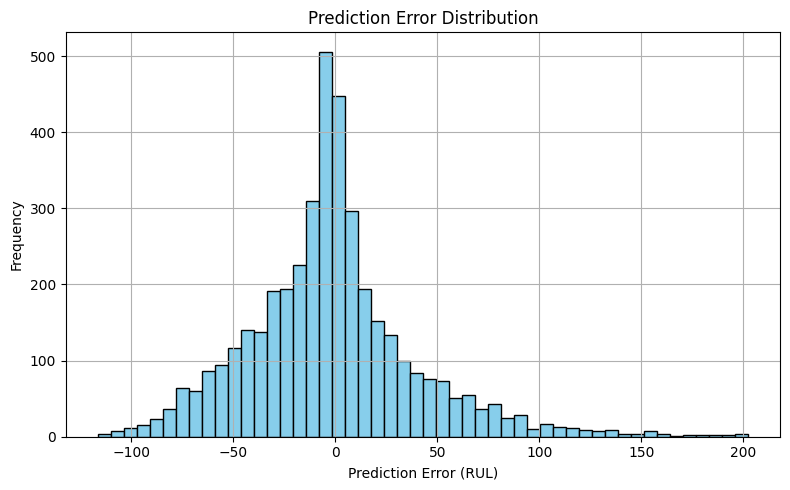

In [29]:
errors = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, color='skyblue', edgecolor='black')
plt.title("Prediction Error Distribution")
plt.xlabel("Prediction Error (RUL)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig("output_plots/error_distribution.png")
plt.show()


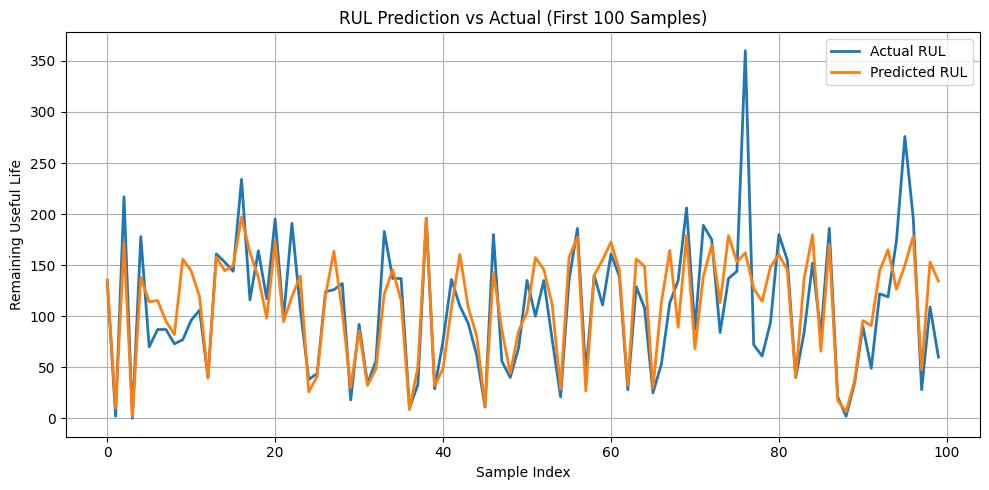

In [28]:
import matplotlib.pyplot as plt

# Plot actual vs predicted RUL for first 100 test samples
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Actual RUL', linewidth=2)
plt.plot(y_pred[:100], label='Predicted RUL', linewidth=2)
plt.title("RUL Prediction vs Actual (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output_plots/actual_vs_predicted.png")
plt.show()




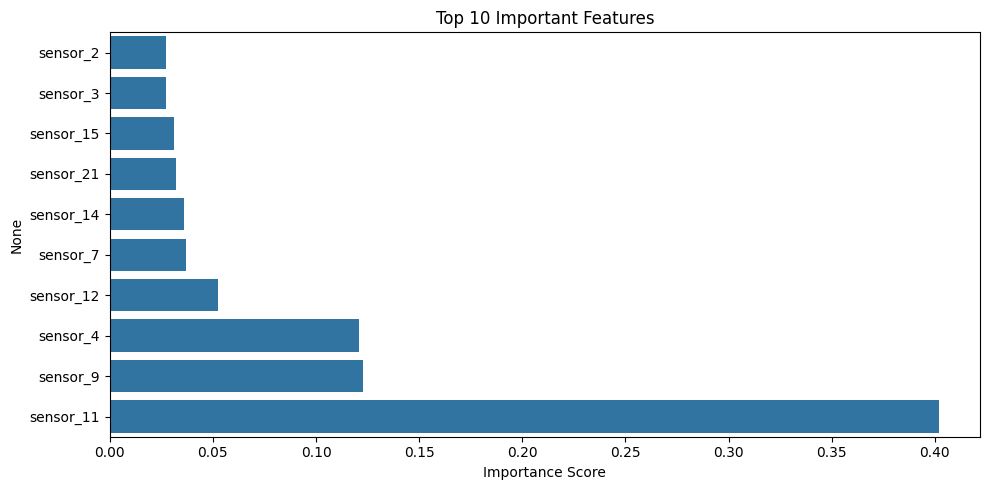

In [30]:
import seaborn as sns

# Get importance and plot top 10
importances = model.feature_importances_
features = X.columns
sorted_idx = importances.argsort()[-10:]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[sorted_idx], y=features[sorted_idx])
plt.title("Top 10 Important Features")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("output_plots/feature_importance.png")
plt.show()


In [19]:
import os
os.listdir('.')


['Untitled.ipynb',
 'rul_prediction.ipynb',
 'CMaps',
 '.ipynb_checkpoints',
 'venv']

In [20]:
import os
os.listdir('CMaps')


['train_FD001.txt']

In [27]:
import os
os.makedirs("output_plots", exist_ok=True)


In [35]:
readme_content = """
# RUL Prediction with Random Forest

This project predicts Remaining Useful Life (RUL) using NASA’s CMAPS dataset and a Random Forest Regressor.

## Overview

- Dataset: NASA CMAPS (train_FD001.txt)
- Model: Random Forest Regressor
- Metrics: MAE = 29.69, RMSE = 41.52
- Visuals: Actual vs Predicted RUL, Feature Importance, Error Distribution

## Highlights

- Data preprocessed by computing max cycle per unit
- Trained on 21 sensor signals and operational settings
- Visualizations provided to explain model behavior

## Structure

icr_ai_project/
├── rul_prediction.ipynb
├── requirements.txt
├── output_plots/
│   ├── actual_vs_predicted.png
│   ├── error_distribution.png
│   └── feature_importance.png
└── README.md

## How to Run

git clone https://github.com/Himansh97/rul-prediction.git  
cd rul-prediction  
pip install -r requirements.txt  
jupyter notebook rul_prediction.ipynb
"""


In [36]:
with open("README.md", "w") as f:
    f.write(readme_content)
